In [90]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

In [91]:
# Transform the dataset into a torch tensor, and have a mean of 0.5 => normalization
# ToTensor() = Convert a PIL Image or numpy.ndarray to tensor
# Normalize() = Normalize a tensor image with mean and standard deviation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])

# Download the datasets and apply the transform on them
train = datasets.MNIST("", download=True, train=True, transform=transform)
test = datasets.MNIST("", download=True, train=False, transform=transform)

# Load each set in batches of 64 images at one time, and shuffle it to better train the model
trainDataLoader = DataLoader(train, batch_size=64, shuffle=True)
testDataLoader = DataLoader(test, batch_size=64, shuffle=True)

In [92]:
images, labels = next(iter(trainDataLoader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


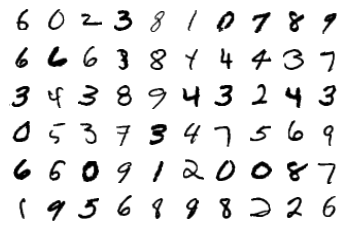

In [93]:
figure = plt.figure()
for index in range(1, 61):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

In [94]:
# The first way to do it is to make a class, and use super to inherit the superclass but for complex neural networks like this one, the nn.Sequential() function is better
"""
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Input 784 x 1 tensor => 128 x 1 tensor => 64 x 1 tensor => 10 outputs
        # Activation function - Tanh (Hyperbolic Tangent)
        self.tanh = nn.Tanh()
        self.input = nn.Linear(784, 256)
        self.HiddenLayer1 = nn.Linear(128, 64)
        self.HiddenLayer2 = nn.Linear(64, 10)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output = self.tanh(self.input(input))
        output = self.tanh(self.HiddenLayer1(input))
        output = self.output(self.HiddenLayer2(input))
        return output

model = NeuralNetwork()
print(model)
"""
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1),
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [95]:
# Loss criterion - Negative likelihood loss
criterion = nn.NLLLoss()
images, labels = next(iter(trainDataLoader))
images = images.view(64, -1)

pred = model(images)
loss = criterion(pred, labels)
print("The initial loss is:", loss.item())

The initial loss is: 2.2526021003723145


In [96]:
# Pass the loss backward - 1st step of backpropagation
print("Before: ", model[0].weight.grad)
loss.backward()
print("After: ", model[0].weight.grad)

Before:  None
After:  tensor([[ 0.0161,  0.0161,  0.0161,  ...,  0.0161,  0.0161,  0.0161],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        ...,
        [-0.0035, -0.0035, -0.0035,  ..., -0.0035, -0.0035, -0.0035],
        [ 0.0048,  0.0048,  0.0048,  ...,  0.0048,  0.0048,  0.0048],
        [ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026]])


In [97]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [98]:
from time import time
epochs = 12 # Number of backpropagation iterations
initialTime = time()
for e in range(1, epochs + 1):
    runningLoss = 0 # defines the loss during each epoch
    for images, labels in trainDataLoader:
        # Head into all the images in the dataset - Total 128 and switch -1 for all
        images = images.view(images.shape[0], -1)

        # Set the gradient to zero to remove accumulated weights
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation   
        loss.backward()

        # Perform gradient descent and add the negative gradient of the cost function to the initial model weights
        optimizer.step()

        runningLoss = runningLoss + loss.item()

    else:
      print("Epoch {} - Loss: {}".format(e, runningLoss/len(trainDataLoader)))
      
print("Total training time: {} min".format((time() - initialTime)/60))

Epoch 1 - Loss: 0.618982237428109
Epoch 2 - Loss: 0.2780677878986925
Epoch 3 - Loss: 0.22268477602522257
Epoch 4 - Loss: 0.1842149533291679
Epoch 5 - Loss: 0.15499326289256118
Epoch 6 - Loss: 0.13409032416083158
Epoch 7 - Loss: 0.11724219557001138
Epoch 8 - Loss: 0.10352240711339374
Epoch 9 - Loss: 0.09341887454551928
Epoch 10 - Loss: 0.08272168593508984
Epoch 11 - Loss: 0.07439514203046732
Epoch 12 - Loss: 0.06904450891716188
Total training time: 2.418371601899465 min


In [99]:
def viewClassifierPredictions(img, ps):
    ps = ps.numpy().squeeze()

    # ncols = 2, bc there are two figures aligned horizontally 
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis("off")
    # Set the length of the horizontal bar to the value of the probability prediction
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_title("Classifier Probabilities")

The digit is: 9


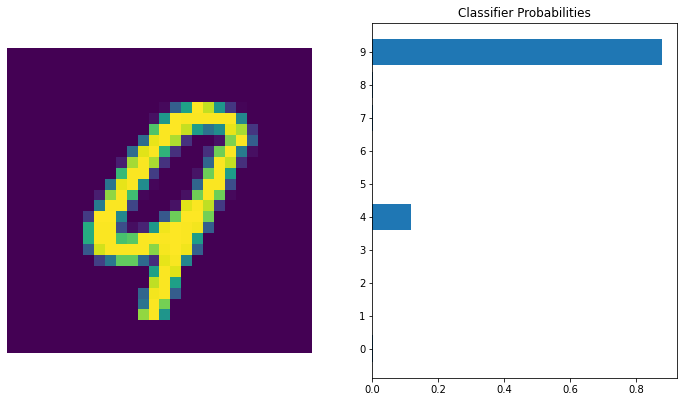

In [100]:
images, labels = next(iter(trainDataLoader))
img = images[0].view(1, 784)

# Speed up the process, by using the model and not adjusting any weights
with torch.no_grad():
    pred = model(img)

# Exponentiate to find the prob, as it is a log(y) function
ps = torch.exp(pred)
prob = list(ps.numpy()[0])
print("The digit is:", prob.index(max(prob)))
viewClassifierPredictions(img, ps)

In [104]:
correct, total = 0, 0
for images, labels in testDataLoader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)

        # Speed up the model process with no gradient
        with torch.no_grad():
            pred = model(img)
        
        pred = torch.exp(pred)
        prob = list(pred.numpy()[0])
        predicted = prob.index(max(prob))
        actual = labels.numpy()[i]
        if predicted == actual:
            correct += 1
        total += 1
accuracy = (correct/total) * 100
accuracy

97.13000000000001

In [32]:
# Finally, let's convert to an mlmodel, which can be shipped to apple devices
import torch
import coremltools as ct

img = images[0].view(1, 784)
# Speed up the process, by using the model and not adjusting any weights
# Save the torch .pt model first
torch.save(model, os.getcwd() + "\\models\\model.pt")
# Trace the model script, and save it as a mlmodel file
tracedModel = torch.jit.trace(model, img)
tracedModel.save("digitRecognition.mlmodel")